### Initializations & Parameters

#### Imports

In [91]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations
from adaptive_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from hexad_answer_bot import *
plt.rcParams["figure.figsize"]=(10,7)
import pandas as pd


#### Environment Init

In [92]:
corr_g_e=list(corr_gamification_elements.values())
sample_g_e=list(sample_gamification_elements.values())
g_e=sample_g_e
hexad=hexad_load_dict(pl=0.5,ach=4,ph=3,dis=2,s=1,fs=5).load_dict
fatigue_penalty=0.03
fatigue_replenishment=0.0025
nothing_reward=50
ranges=(1.0,1.3,1.7)
increase=(0.2,0.05,0.05)
decrease=(0.05,0.1,0.1)
pref_min=0.2
seed=101

In [93]:
1/(fatigue_replenishment/fatigue_penalty)

11.999999999999998

In [94]:
env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=g_e,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(400,800),
               nothing_reward=nothing_reward,
               fatigue_reduction=fatigue_penalty,
               fatigue_replenish=fatigue_replenishment,
               pref_ranges=ranges,
               pref_increase=increase,
               pref_decrease=decrease,
               pref_min=pref_min,
               seed=seed
               )
obs,_=env.reset()

#### Answer Bot Init

In [95]:
uncertainty=.2
divisor=5.5
starting_threshold=.1
gain_modifier=0.02
amount=1


In [96]:
bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(hexad),
        uncertainty= uncertainty,
        divisor=divisor,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )

#### Agent init

In [97]:
#general parameters
learn_rate=0.002
discount_factor=0.5

In [98]:
#Fatigue-aware parameters
epsilon=1
epsilon_min=0.1
training_iterations=int(1e6)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [99]:
fa_agent=FatigueAwareAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=fa_agent.train(env=env,iterations=training_iterations,trunc_error=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [100]:
#Epsilon agent parameters
epsilon=1
epsilon_min=0.1
training_iterations=int(1e6)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [101]:
e_agent=EpsilonAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )

train_error=e_agent.train(env=env,iterations=training_iterations,trunc_error=True)

In [102]:

basic_agent=BasicAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   )
train_error=basic_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [103]:
#RandomBestOfX parameters
epsilon=1
epsilon_min=0.1
training_iterations=int(1e6)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*4/5000)
x=3

In [104]:

boX_agent=RandomBestOfX(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   X=x
                   )

train_error=boX_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [105]:
agents={"Basic":basic_agent,"Epsilon":e_agent,"BestOfX":boX_agent,"FatigueAware":fa_agent}

#### Testing Functions

In [106]:

def test_env_agent(env,agent,answer_bot,test_iterations,retrain_iterations,random_retrain,training_lr):
    rewards=[]
    choices=[]
    best=[]
    agent_error=[]
    actions=defaultdict(lambda:{'x':[],'y':[]})
    obs,info=env.reset()
    for i in tqdm(range(test_iterations),leave=False):
        best.append(env.get_best_action())
        act=agent.get_action(obs,avoid_reps=True)
        h_type=env.ge[env.action_to_ge[act]].type
        answer,_=answer_bot.get_answer(h_type)
        choice,reward,new_obs,info,error=agent\
            .step_and_update(env=env,
                            obs=obs,
                            answer=answer,
                            retrain_iterations=retrain_iterations,
                            learning_rate=training_lr,
                            random_retrain=random_retrain,
                            act=act)
        choices.append(choice)
        rewards.append(reward)
        agent_error.append(error)
        actions[choice]['x'].append(i)
        actions[choice]['y'].append(reward)
        obs=new_obs
    return rewards,choices,best,agent_error,actions,(obs,info)

In [107]:
def plot_actions(actions,env,title=None,f=1):
    typ='pl'
    fig=plt.figure(f,figsize=(12,7))
    fig.suptitle(title)
    for i,_ in sorted(actions.items()):
        name=env.action_to_ge[i]
        hex_type=env.ge[name].type
        if hex_type!=None:
            plt.figure(f)
            type_index=hexad_types.index(env.ge[name].type)+1
        else:
            plt.figure(f+1)
        plt.subplot(3,2,type_index)
        plt.ylim(0,1000)
        plt.xlim(0,1000)
        plt.scatter(actions[i]['x'],actions[i]['y'],label=name,s=2)
        ax=plt.gca()
        ax.legend()
    plt.figure(f+2)
    fig.suptitle(title)
    for i in actions:
        plt.scatter(actions[i]['x'],actions[i]['y'],label=env.action_to_ge[i],s=5)
        ax=plt.gca()
        ax.legend()

In [108]:
def get_stats(actions,best,choices):
    type_stats=defaultdict(lambda:0)
    for i in actions:
        try:
            type_stats[sample_gamification_elements[env.action_to_ge[i]].type]+=len(actions[i]['x'])
        except KeyError:
            type_stats['None']+=len(actions[i]['x'])
    s=0
    for i in range(len(best)):
        if best[i][1]==choices[i][1]:
            s+=1
    diff=[best[i][1]-choices[i][1] for i in range(len(choices))]
    actual=pd.Series([env.action_to_ge[item[0]] for item in best],name="Actual Best")
    pred = pd.Series([env.action_to_ge[item[0]] for item in b],name="Predicted Best")
    conf_matrix=pd.crosstab(actual,pred,margins=True)
    return type_stats,s/len(best),diff,conf_matrix

### Testing

In [109]:
tests=1000
retrains=4000
retrain_learn_rate=0.5

In [110]:
rewards={}
choices={}
best_choices={}
agent_error={}
actions={}
for name,agent in agents.items():
    print(name)
    random_retrain=(name in ["Basic","BestOfX"])
    r,c,b,e,a,_=test_env_agent(env,agent,
                   answer_bot=bot,
                   test_iterations=tests,
                   retrain_iterations=retrains,
                   random_retrain=random_retrain,
                   training_lr=retrain_learn_rate)
    rewards[name]=r
    choices[name]=c
    best_choices[name]=b
    agent_error[name]=e
    actions[name]=a
    bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(hexad),
        uncertainty= uncertainty,
        divisor=divisor,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )

Basic


Epsilon


BestOfX


FatigueAware


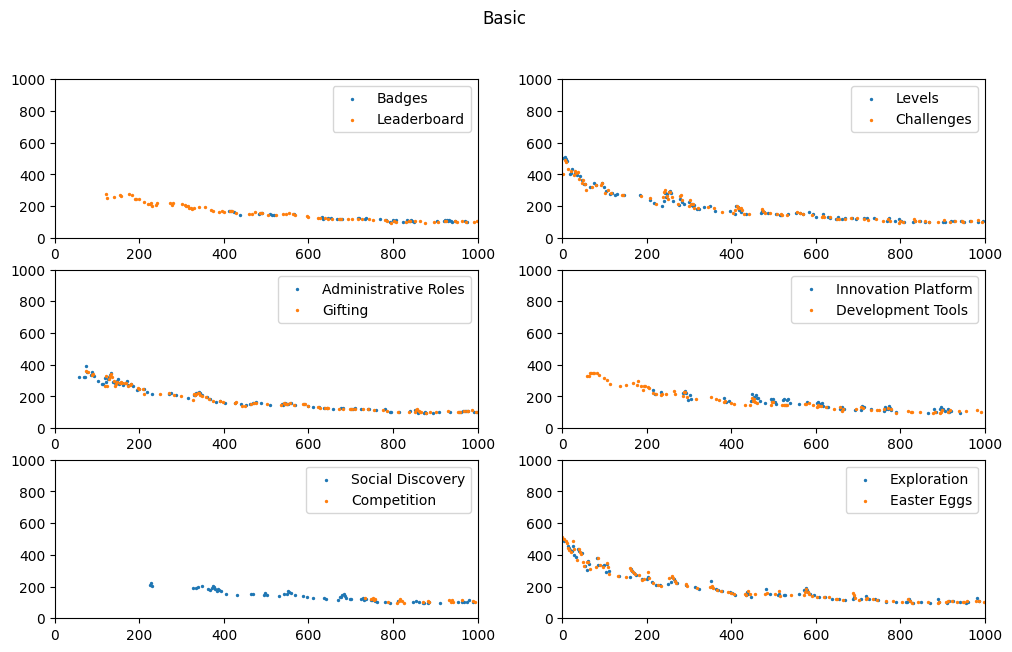

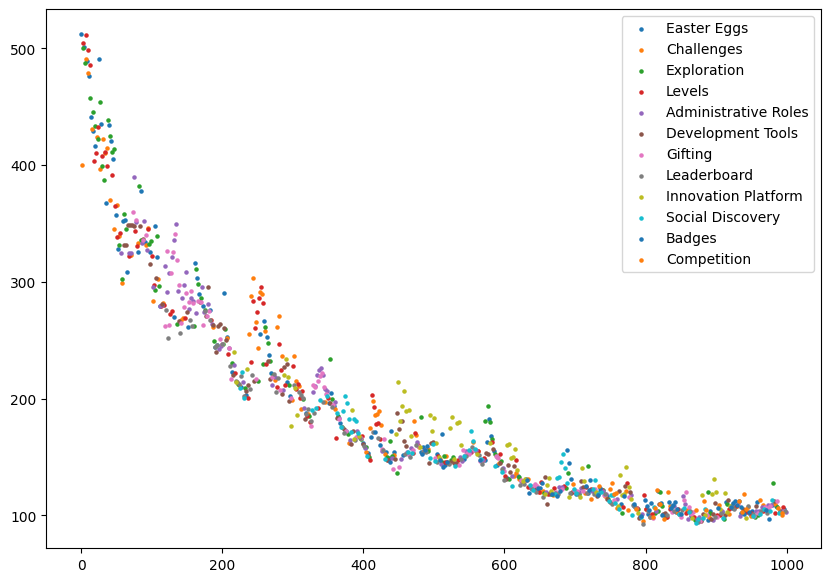

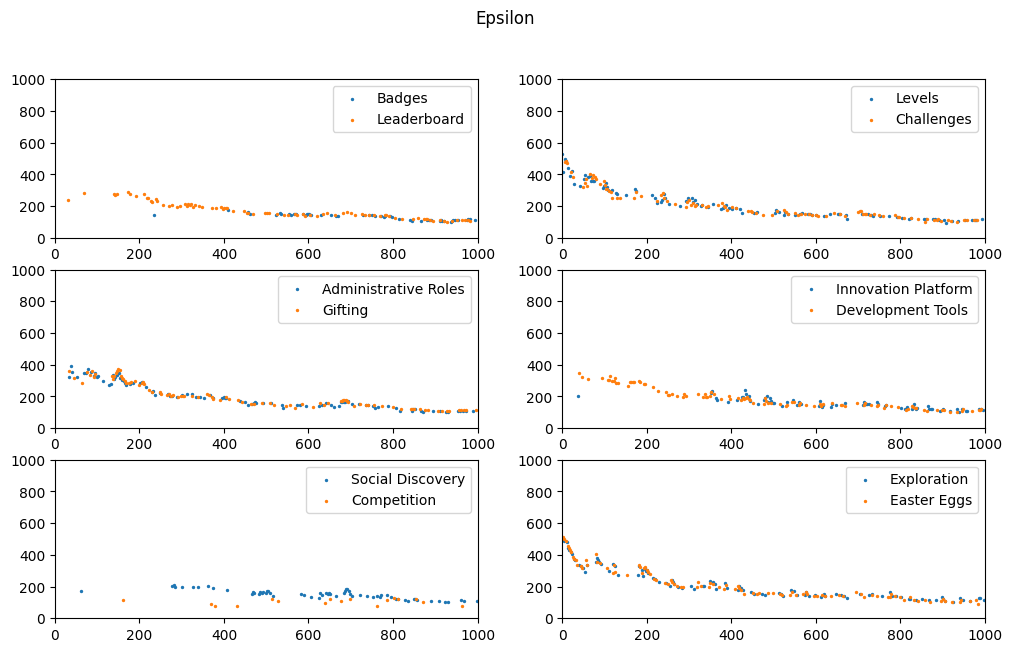

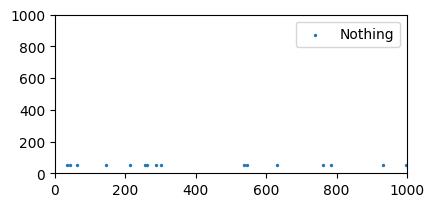

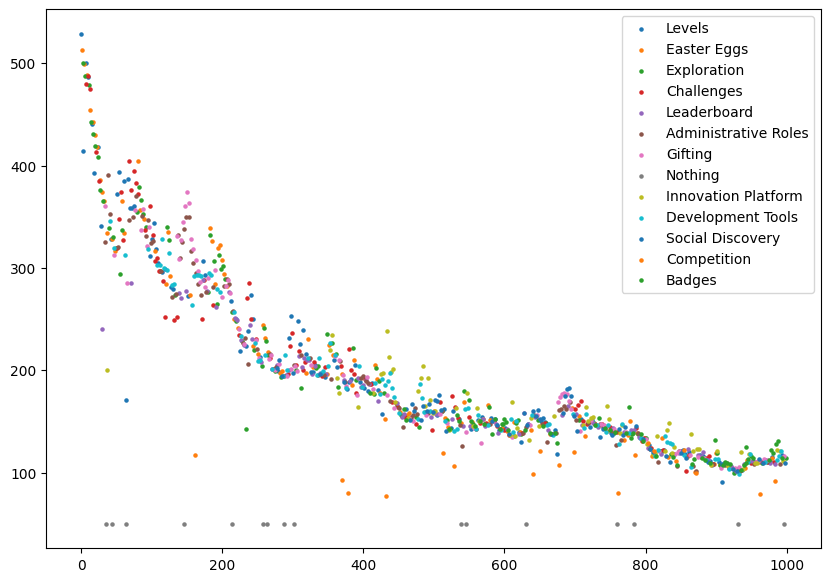

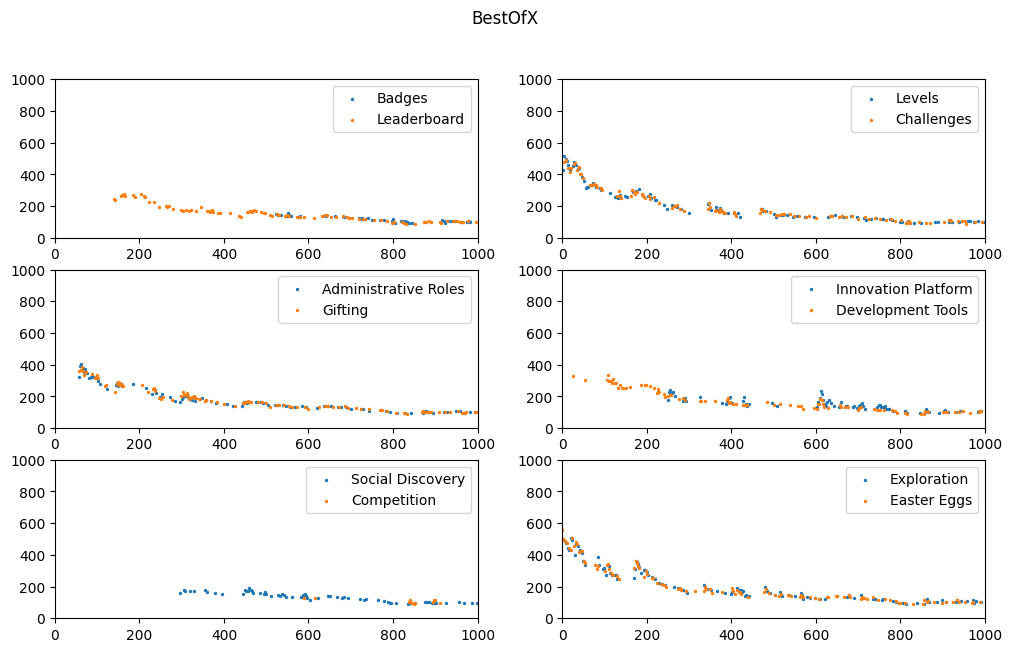

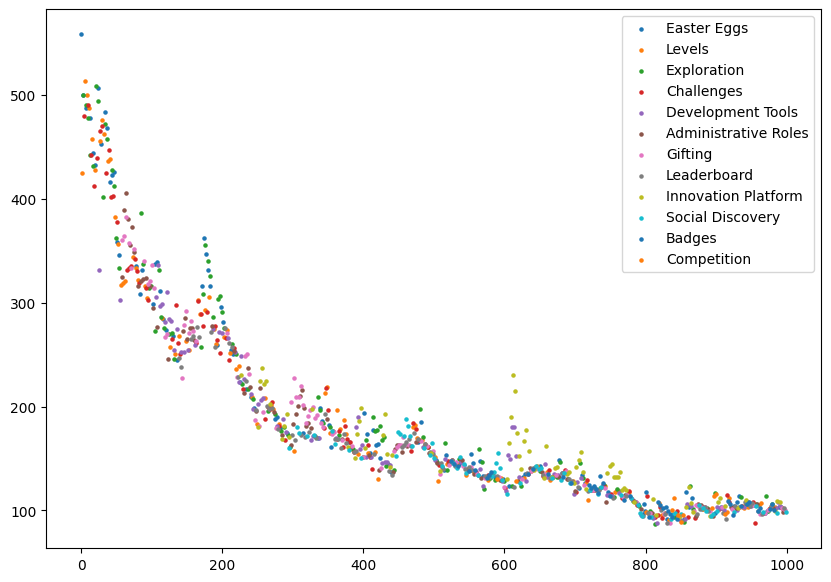

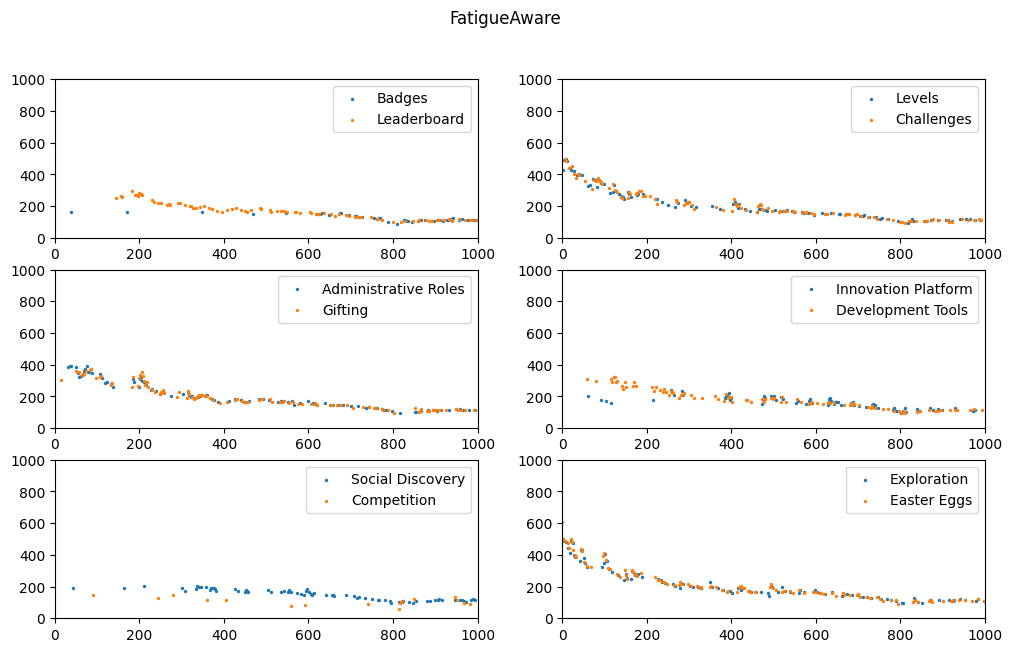

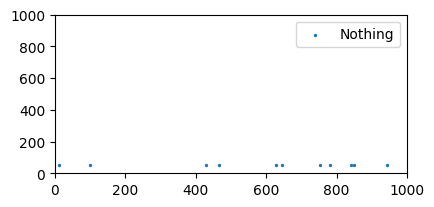

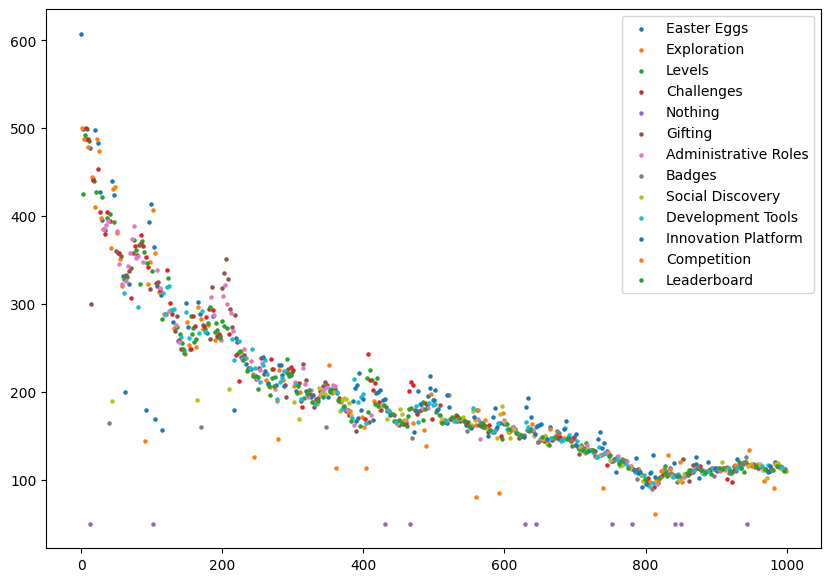

In [111]:
f=1
for name,acts in actions.items():
    plot_actions(actions=acts,env=env,title=name,f=f)
    f+=3

In [112]:
agent_error["Epsilon"]=agent_error["Epsilon"][1:]

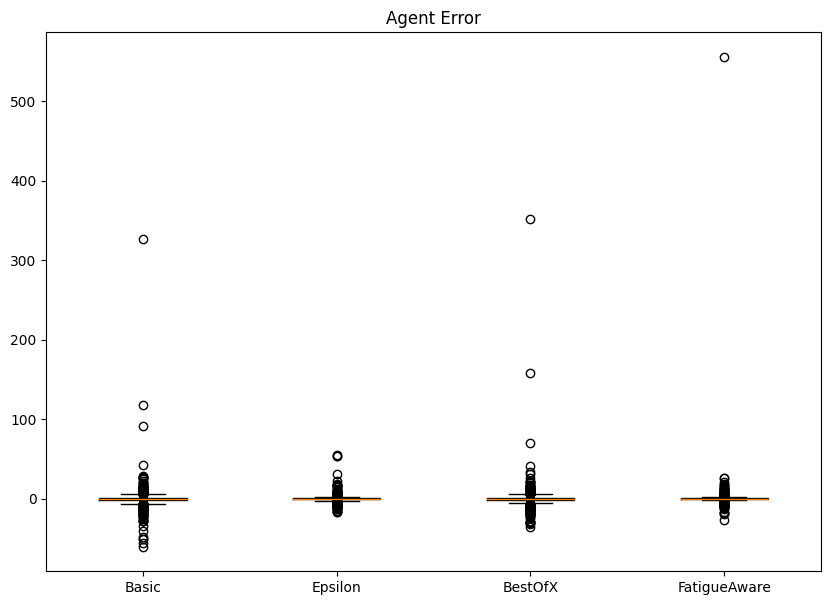

In [113]:
fig=plt.figure()
plt.title("Agent Error")
bp=plt.boxplot(agent_error.values(),labels=agent_error.keys())

In [114]:
type_stats={}
accuracies={}
diff_from_best={}
confusion_matrices={}
for agent in agents:
    t,acc,diff,conf_matrix = get_stats(actions[agent],best_choices[agent],[*zip(choices[agent],rewards[agent])])
    type_stats[agent]=t
    accuracies[agent]=acc
    diff_from_best[agent]=diff
    confusion_matrices[agent]=conf_matrix

Text(0.5, 1.0, 'Agent Accuracy')

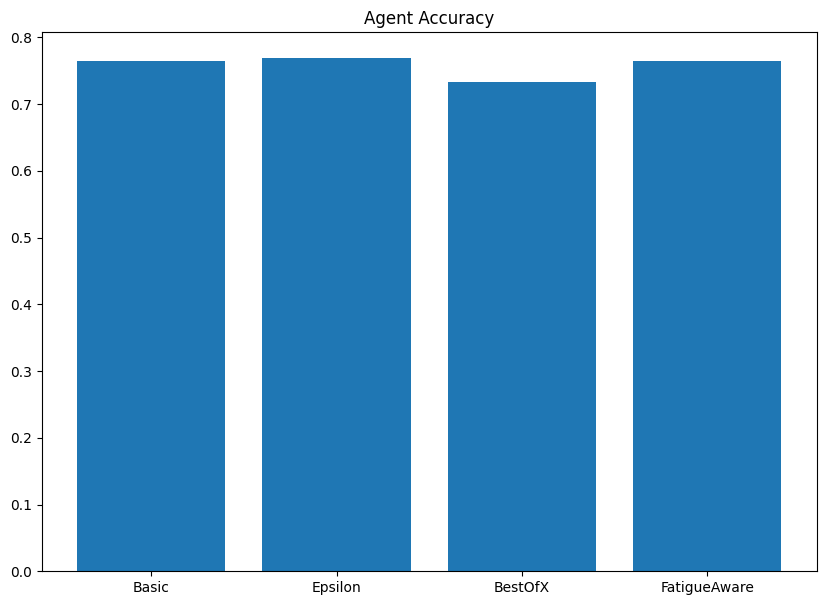

In [115]:
plt.bar(accuracies.keys(),accuracies.values())
plt.title("Agent Accuracy")

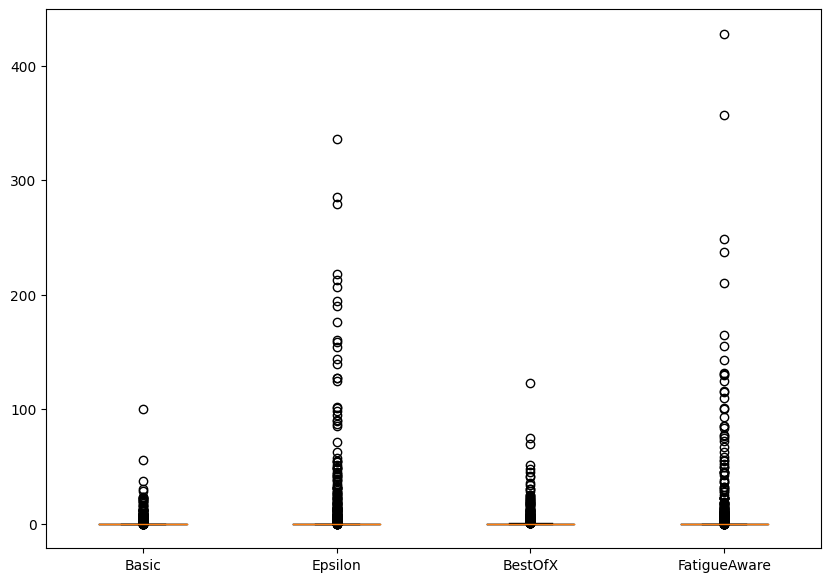

In [116]:
bp=plt.boxplot(diff_from_best.values(),labels=diff_from_best.keys())